# Part 1 : Implementing QPE

## To hand out

1. A **report** with your answers in a **PDF FILE** (made out of LaTeX, libreoffice, ...)
  * Math and text answers
  * The code for the circuits
  * Screenshot of figures/circuits
  * python answers and results of runs
  * *etc*
  
2. **This notebook**
  * as a runnable script

But first, some libraries to load (nothing to modify here)

In [56]:
import numpy as np
from math import pi, gcd
try:
    from qiskit import *
    from qiskit_aer import AerSimulator
    from matplotlib.pyplot import plot,show
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit qiskit-aer
from qiskit import *
from qiskit.circuit import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit_aer import AerSimulator, StatevectorSimulator
import matplotlib.pyplot as plt 

from qiskit_aer import AerSimulator, StatevectorSimulator


# 0 - Before anything else

### Make sure you checked the notebook TP-Intro-QisKit


# 1 - Small practice

To start, check that when we measure $\frac1{\sqrt2}(|000\rangle+|111\rangle)$ we indeed get 000 and 111 about the same number of times. 

{'000': 507, '111': 493}


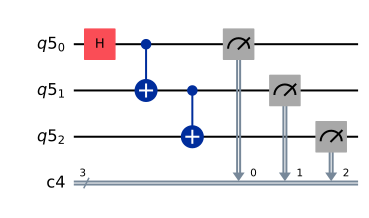

In [57]:
# Generating the circuit

q = QuantumRegister(3)   # We need 3 qubits..
c = ClassicalRegister(3) # ... and 3 bits to store the results
qc = QuantumCircuit(q,c) # the circuit !

qc.h(q[0])
qc.cx(q[0],q[1])
qc.cx(q[1],q[2])
qc.measure(q, c)

simulator = AerSimulator()
job = simulator.run(qc, shots=1000)
res = dict(job.result().get_counts(qc))
res

simulator = AerSimulator()
job = simulator.run(qc, shots=1000)
res = dict(job.result().get_counts(qc))
print(res)

qc.draw(output='mpl')  # Affiche le circuit en graphique


#### Write record what you did and what you see in the separate report

# 2 - QPE

We've seen the QPE algorithm in the course, and you checked it worked with 3 qubits. Here we are going to implement it with the following unitary:

In [58]:
U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*2j*(1/8))]]), label="U")

## Questions 

###  Q 2.1 Math questions

* What is doing this operator ? (`2j` is in Python the complex number $2\cdot i$)
* On how many qubits does it act ?
* What are its eigenvalues/eigenvectors ?
* For each eigenvector, what should QPE return with 3 bits of precisions, as seen in the course ?

#### Give answers and explanations in the separate report 

### Q 2.2 Implementing QPE

Below a template to fill in for
- realize QPE with 3 bits of precision.
- on the eigenvector of non-trivial eigenvalue

We initialized a quantum circuit with 3 registers:
 - `eig` for storing the eigenvalues
 - `phi` for storing the eigenvector
 - `ceig` for storing the result of the measurement of the eigenvalue-register.
 
Note that we only need to measure the eigenvalues!

What you will need:
 - `QFT(size)` build for you a QFT on `size` qubits.
 - `U.control()` for controlling a gate `U`. The control qubit should be placed first in the list of wires.
 - `U.inverse()` for the inverse of the gate `U`.
 - `U.power(p)` add `p` times `U` on the circuit.
 - `qc.append(U, list_of_qubits)` applies the gate `U` on the list of qubits.
 - Beware : `phi` (for instance) is not a list but a register. So if you want to concatenate it with something else, you first have to make a list out of it with `list(phi)`.

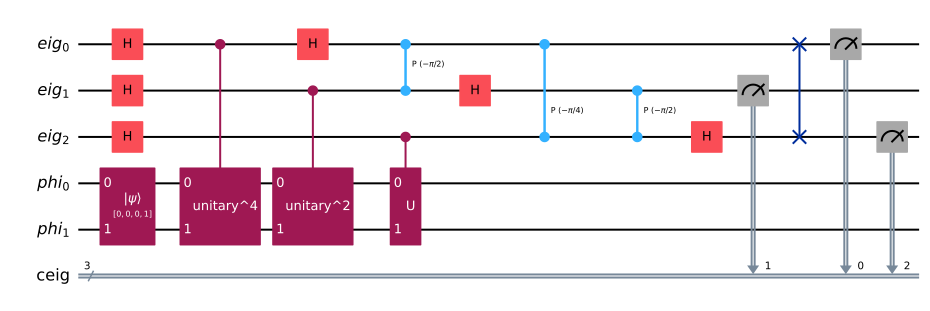

In [59]:
size_eig = 3
size_phi = 2

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)

# Initialisation des qubits dans phi à l'état |11⟩
initial_state = [0, 0, 0, 1]  # État |11⟩
qc.initialize(initial_state, phi)
qc.h(eig[0])
qc.h(eig[1])
qc.h(eig[2])

qc.append(U.power(4).control(), [eig[0], *phi])  # Control dans eig[2]
qc.append(U.power(2).control(), [eig[1], *phi])  # Control dans eig[1]
qc.append(U.control(), [eig[2], *phi])           # Control dans eig[0]

def inverse_qft(circuit, qubits):
    n = len(qubits)
    for j in range(n):
        for k in range(j):
            circuit.cp(-np.pi / (2 ** (j - k)), qubits[j], qubits[k])
        circuit.h(qubits[j])
    for j in range(n // 2):
        circuit.swap(qubits[j], qubits[n - j - 1])


inverse_qft(qc, eig)
qc.measure(eig,ceig)
qc.draw(output='mpl')

In [60]:
simulator = AerSimulator()
job = simulator.run(qc.decompose(reps=6), shots=1000)
job_result = job.result()
res = dict(job.result().get_counts(qc))
res = {key[::-1]: value for key, value in job_result.get_counts(qc).items()}
res

{'001': 1000}

### Q 2.3 Exact result

- (a) Is it the expected result ?
- (b) Change the $\frac68$ of the phase of $U$: use $\frac18$, then $\frac28$... Is QPE returning the correct answer?
- (c) Change the precision : use $4$ qubits for `eig`, and change the fraction in the phase of $U$ to $\frac{10}{16}$ : is QPE indeed returning $10$ in binary ?
- (d) Move to $5$ bits of précision: is it still working ?

#### Give answers and explanations in the separate report 

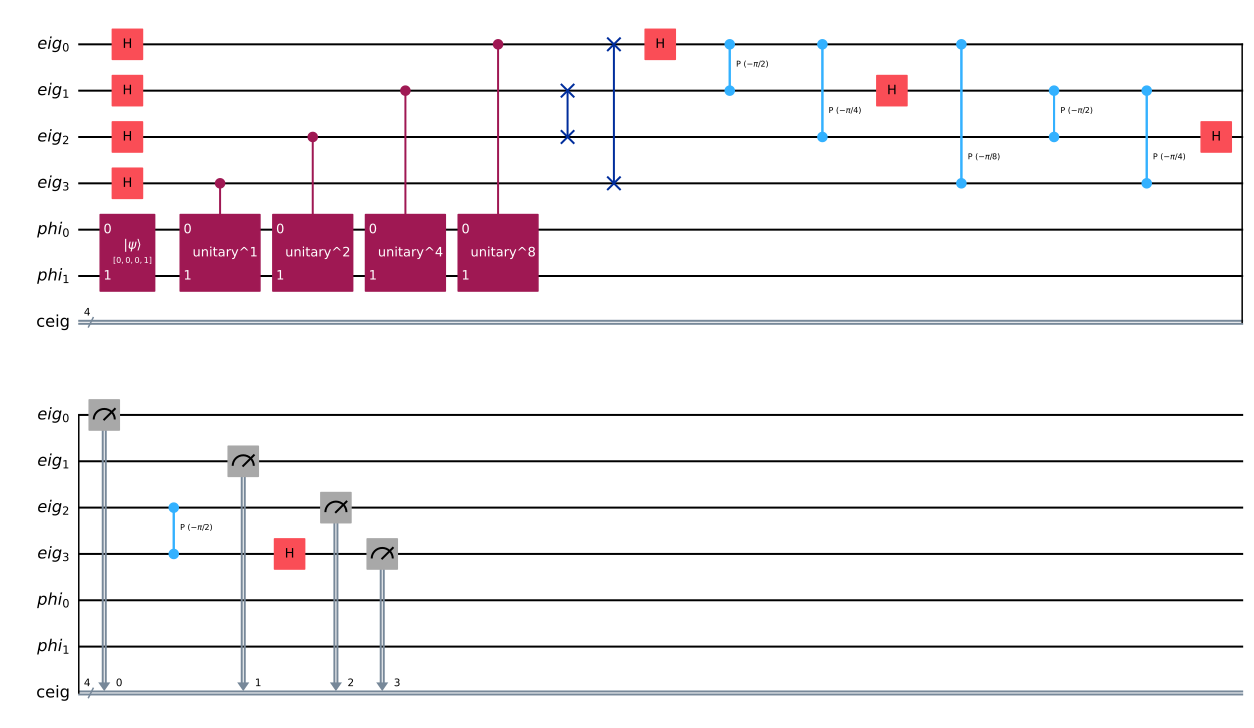

In [61]:
size = 4  
size_phi = 2  

eig = QuantumRegister(size, name="eig")          
phi = QuantumRegister(size_phi, name="phi")       
ceig = ClassicalRegister(size, name="ceig")     
qc = QuantumCircuit(eig, phi, ceig)

# Initialisation spécifique des qubits dans phi à l'état |11⟩
initial_state = [0, 0, 0, 1]  # État |11⟩
qc.initialize(initial_state, phi)


for qubit in eig:
    qc.h(qubit)

phase_fraction = 10 / 16
U = UnitaryGate(
    Operator([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, np.exp(2j * np.pi * phase_fraction)]
    ]), label="U"
)


for i in range(size):
    power = 2 ** i  # Calcule la puissance de U pour chaque qubit de eig
    qc.append(U.power(power).control(), [eig[size - i - 1]] + phi[:])  # Contrôle sur eig[size - i - 1]

def inverse_qft(circuit, qubits):
    n = len(qubits)
    for j in range(n // 2):
        # Échange les qubits j et n-j-1 pour inverser l'ordre
        circuit.swap(qubits[j], qubits[n - j - 1])
    for j in range(n):
        circuit.h(qubits[j])
        for k in range(j + 1, n):
            angle = -np.pi / (2 ** (k - j))
            circuit.cp(angle, qubits[k], qubits[j])

inverse_qft(qc, eig)
qc.measure(eig, ceig)
qc.draw(output='mpl') 



{'0100': 32, '1101': 489, '1010': 8, '0001': 121, '0101': 242, '1110': 25, '0010': 32, '1100': 41, '0110': 7, '1001': 3}


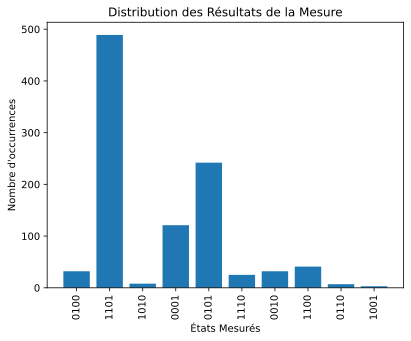

In [62]:
simulator = AerSimulator()
job = simulator.run(qc.decompose(reps=6), shots=1000)
job_result = job.result()

# Récupération des résultats
res = dict(job.result().get_counts(qc))

# Affichage des résultats dans la console
print(res)

# Tracer un histogramme avec matplotlib
labels, values = zip(*res.items())
indices = np.arange(len(labels))
plt.bar(indices, values, tick_label=labels)
plt.xlabel('États Mesurés')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des Résultats de la Mesure')
plt.xticks(rotation=90)
plt.show()


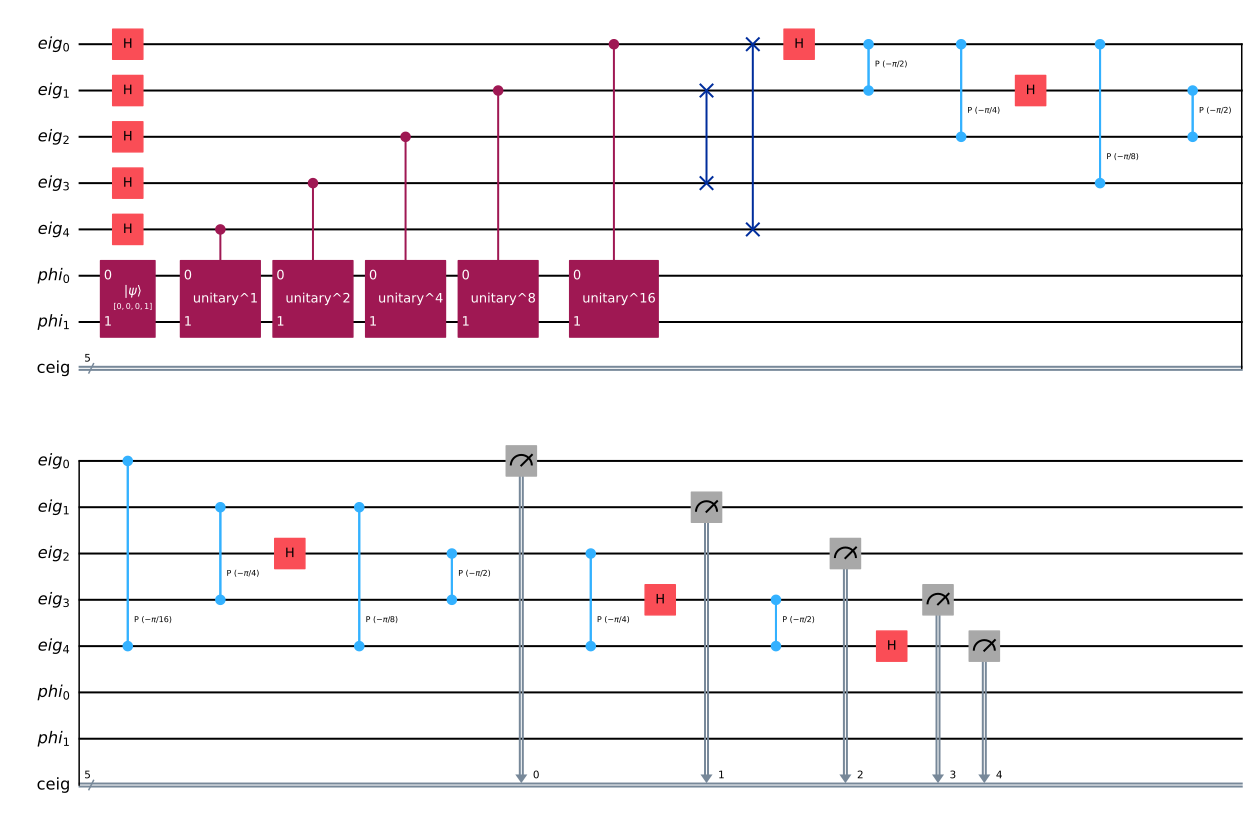

In [ ]:

size = 5  
size_phi = 2  

eig = QuantumRegister(size, name="eig")           
phi = QuantumRegister(size_phi, name="phi")      
ceig = ClassicalRegister(size, name="ceig")     
qc = QuantumCircuit(eig, phi, ceig)

# Initialisation spécifique des qubits dans phi à l'état |11⟩
initial_state = [0, 0, 0, 1]  # État |11⟩
qc.initialize(initial_state, phi)

for qubit in eig:
    qc.h(qubit)

phase_fraction = 10 / 16
U = UnitaryGate(
    Operator([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, np.exp(2j * np.pi * phase_fraction)]
    ]), label="U"
)

for i in range(size):
    power = 2 ** i  # Calcule la puissance de U pour chaque qubit de eig
    qc.append(U.power(power).control(), [eig[size - i - 1]] + phi[:])  # Contrôle sur eig[size - i - 1]

def inverse_qft(circuit, qubits):
    n = len(qubits)
    for j in range(n // 2):
        # Échange les qubits j et n-j-1 pour inverser l'ordre
        circuit.swap(qubits[j], qubits[n - j - 1])
    for j in range(n):
        circuit.h(qubits[j])
        # Appliquer les rotations contrôlées inverses
        for k in range(j + 1, n):
            angle = -np.pi / (2 ** (k - j))
            circuit.cp(angle, qubits[k], qubits[j])

inverse_qft(qc, eig)
qc.measure(eig, ceig)
qc.draw(output='mpl')  # Affiche le circuit en graphique


Résultats de mesure: {'00001': 128, '00101': 183, '11101': 463, '01101': 49, '10101': 59, '01100': 9, '10001': 1, '00010': 21, '11100': 19, '11110': 27, '00100': 26, '00110': 2, '10100': 3, '11010': 3, '10010': 2, '11001': 3, '01110': 1, '01001': 1}


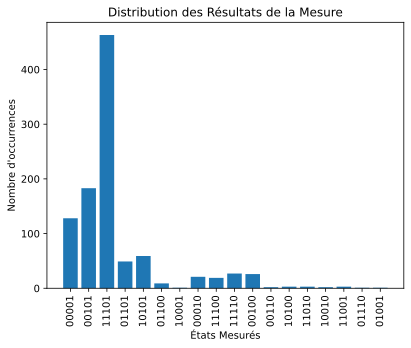

In [ ]:

simulator = AerSimulator()
job = simulator.run(qc.decompose(reps=6), shots=1000)
job_result = job.result()

res = dict(job_result.get_counts(qc))
print("Résultats de mesure:", res)

# Tracer un histogramme avec matplotlib
labels, values = zip(*res.items())
indices = np.arange(len(labels))
plt.bar(indices, values, tick_label=labels)
plt.xlabel('États Mesurés')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution des Résultats de la Mesure')
plt.xticks(rotation=90)
plt.show()

### Q 2.4 Approximate result

Use  $\frac13$ in the phase of $U$:
- With 3 bits of precision
- With 4 bits of precision
- With 5 bits of precision

**Question** What do you observe? Can you explain it? What do you read?

Résultats de mesure pour 3 bits de précision : {'010': 154, '011': 673, '001': 39, '111': 20, '000': 18, '100': 56, '110': 17, '101': 23}


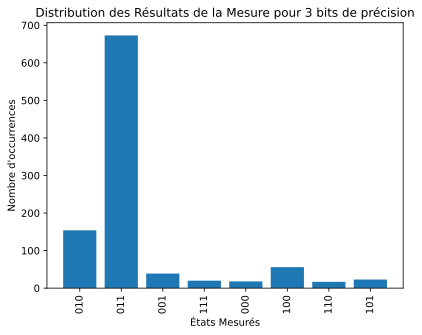

Résultats de mesure pour 4 bits de précision : {'1011': 679, '1010': 168, '1000': 13, '0000': 4, '1100': 59, '1101': 15, '0111': 3, '0110': 6, '1001': 23, '0101': 2, '1110': 8, '0001': 7, '0100': 5, '1111': 3, '0010': 4, '0011': 1}


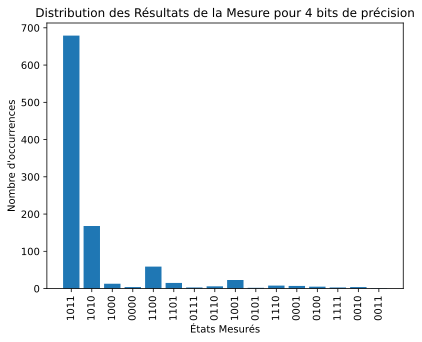

Résultats de mesure pour 5 bits de précision : {'01011': 669, '01001': 29, '01010': 181, '01000': 9, '01111': 7, '10101': 1, '01101': 18, '00111': 4, '00010': 4, '01100': 41, '00001': 1, '10000': 2, '01110': 7, '10100': 2, '00110': 5, '10111': 1, '10001': 1, '00000': 2, '11001': 1, '00100': 2, '10011': 1, '10010': 2, '00101': 2, '11000': 1, '00011': 1, '11101': 1, '11010': 1, '11100': 1, '11110': 2, '11111': 1}


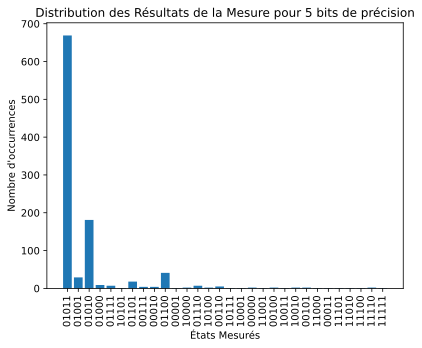

In [ ]:


def run_qpe(precision_bits, phase_fraction):
    eig = QuantumRegister(precision_bits, name="eig")      # Registre pour les valeurs propres
    phi = QuantumRegister(2, name="phi")                   # Registre pour le vecteur propre
    ceig = ClassicalRegister(precision_bits, name="ceig")  # Registre classique pour stocker la mesure
    qc = QuantumCircuit(eig, phi, ceig)

    initial_state = [0, 0, 0, 1]  # État |11⟩
    qc.initialize(initial_state, phi)

    for qubit in eig:
        qc.h(qubit)

    U = UnitaryGate(
        Operator([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, np.exp(2j * np.pi * phase_fraction)]
        ]), label="U"
    )

    for i in range(precision_bits):
        power = 2 ** i  # Calcule la puissance de U pour chaque qubit de eig
        qc.append(U.power(power).control(), [eig[precision_bits - i - 1]] + phi[:])

    def inverse_qft(circuit, qubits):
        n = len(qubits)
        for j in range(n // 2):
            circuit.swap(qubits[j], qubits[n - j - 1])
        for j in range(n):
            # Appliquer une porte Hadamard
            circuit.h(qubits[j])
            # Appliquer les rotations contrôlées inverses
            for k in range(j + 1, n):
                angle = -np.pi / (2 ** (k - j))
                circuit.cp(angle, qubits[k], qubits[j])

    inverse_qft(qc, eig)
    qc.measure(eig, ceig)

    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=6), shots=1000)
    job_result = job.result()
    res = dict(job_result.get_counts(qc))
    print(f"Résultats de mesure pour {precision_bits} bits de précision :", res)
    labels, values = zip(*res.items())
    indices = np.arange(len(labels))
    plt.bar(indices, values, tick_label=labels)
    plt.xlabel('États Mesurés')
    plt.ylabel("Nombre d'occurrences")
    plt.title(f'Distribution des Résultats de la Mesure pour {precision_bits} bits de précision')
    plt.xticks(rotation=90)
    plt.show()

phase_fraction = 1 / 3
run_qpe(3, phase_fraction)  # 3 bits de précision
run_qpe(4, phase_fraction)  # 4 bits de précision
run_qpe(5, phase_fraction)  # 5 bits de précision


#### Give answers and explanations in the separate report 

### Q 2.5 Superposition

We saw that the circuit of QPE has no problem with a superposition of eigenvectors. Try to change the initialization of `phi` with 
$$
\frac1{\sqrt2}(|\phi_1\rangle + |\phi_2\rangle),
$$
two eigenvectors of $U$ (one with trivial eigenvalue, the other one non-trivial).

Also measure the register `phi` at the end of the circuit, and analyze the result: can you explain what you see?

Try this experiment with phase $\frac38$ and $\frac13$.

#### Give answers and explanations in the separate report 

Résultats de mesure pour 5 bits de précision avec phase 3/8 :
Résultats de eig : {'11100': 9, '00000': 758, '10011': 10, '11011': 32, '00011': 124, '11111': 24, '01011': 10, '11110': 10, '00100': 7, '01100': 3, '00010': 9, '10100': 3, '11010': 1}
Résultats de phi : {'11': 242, '00': 238, '01': 258, '10': 262}


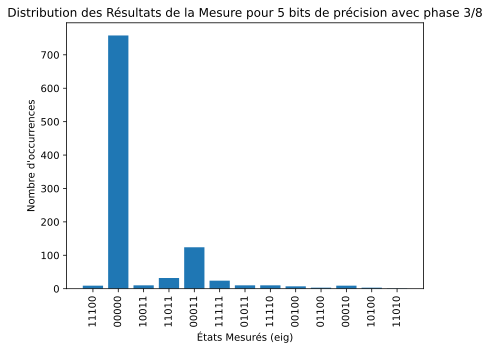

Résultats de mesure pour 5 bits de précision avec phase 1/3 :
Résultats de eig : {'01011': 160, '00000': 761, '01101': 8, '10011': 1, '01100': 13, '01010': 37, '01111': 3, '01110': 4, '10101': 1, '01001': 4, '01000': 4, '10100': 1, '00111': 2, '00110': 1}
Résultats de phi : {'11': 239, '10': 259, '01': 235, '00': 267}


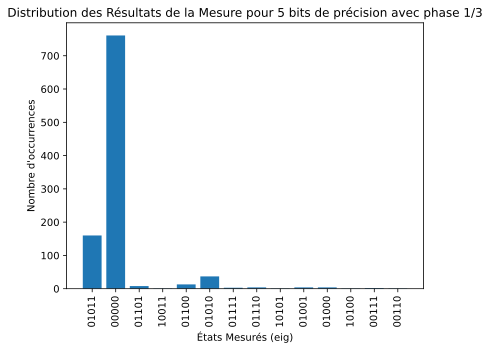

In [ ]:
def run_qpe_superposition(precision_bits, phase_fraction, phase_label):
    eig = QuantumRegister(precision_bits, name="eig")      # Registre pour les valeurs propres
    phi = QuantumRegister(2, name="phi")                   # Registre pour le vecteur propre en superposition
    ceig = ClassicalRegister(precision_bits, name="ceig")  # Registre classique pour stocker la mesure de eig
    cphi = ClassicalRegister(2, name="cphi")               # Registre classique pour mesurer `phi`
    qc = QuantumCircuit(eig, phi, ceig, cphi)
    initial_state = [0, 0, 0, 1]  # État |11⟩
    qc.initialize(initial_state, phi)

    qc.h(phi[0])
    qc.x(phi[1])
    qc.h(phi[1])

    for qubit in eig:
        qc.h(qubit)

    U = UnitaryGate(
        Operator([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, np.exp(2j * np.pi * phase_fraction)]
        ]), label="U"
    )
    for i in range(precision_bits):
        power = 2 ** i  # Calcule la puissance de U pour chaque qubit de eig
        qc.append(U.power(power).control(), [eig[precision_bits - i - 1]] + phi[:])

    def inverse_qft(circuit, qubits):
        n = len(qubits)
        for j in range(n // 2):
            # Échange les qubits j et n-j-1 pour inverser l'ordre
            circuit.swap(qubits[j], qubits[n - j - 1])
        for j in range(n):
            # Appliquer une porte Hadamard
            circuit.h(qubits[j])
            # Appliquer les rotations contrôlées inverses
            for k in range(j + 1, n):
                angle = -np.pi / (2 ** (k - j))
                circuit.cp(angle, qubits[k], qubits[j])
    inverse_qft(qc, eig)
    qc.measure(eig, ceig)
    qc.measure(phi, cphi)
    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=6), shots=1000)
    job_result = job.result()

    counts = job_result.get_counts(qc)
    res_eig = {}
    res_phi = {}
    for outcome, count in counts.items():
        outcome_eig = outcome[-precision_bits:]  # Bits de `ceig`
        outcome_phi = outcome[:2]               # Bits de `cphi`
        if outcome_eig in res_eig:
            res_eig[outcome_eig] += count
        else:
            res_eig[outcome_eig] = count
        
        if outcome_phi in res_phi:
            res_phi[outcome_phi] += count
        else:
            res_phi[outcome_phi] = count

    print(f"Résultats de mesure pour {precision_bits} bits de précision avec phase {phase_label} :")
    print("Résultats de eig :", res_eig)
    print("Résultats de phi :", res_phi)

    labels, values = zip(*res_eig.items())
    indices = np.arange(len(labels))
    plt.bar(indices, values, tick_label=labels)
    plt.xlabel('États Mesurés (eig)')
    plt.ylabel("Nombre d'occurrences")
    plt.title(f'Distribution des Résultats de la Mesure pour {precision_bits} bits de précision avec phase {phase_label}')
    plt.xticks(rotation=90)
    plt.show()

# Tester avec superposition pour deux phases : 3/8 et 1/3
run_qpe_superposition(5, 3 / 8, "3/8")  # Phase de 3/8
run_qpe_superposition(5, 1 / 3, "1/3")  # Phase de 1/3